## Libraries

All libraries used in this notebook are presented below

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import kagglehub
import shutil
import random
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance
import eli5
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers, models, regularizers, Model
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from PIL import Image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pathlib import Path
from collections import defaultdict
import hashlib
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.utils.class_weight import compute_class_weight


## Machine Learning

For the first part, we are gonna choose, train and classify images using a Machine Learning model

#### Import Dataset

In [2]:
# Download latest version from the Dataset
path = kagglehub.dataset_download("uciml/iris")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\LuizFernandoDaCostaC\.cache\kagglehub\datasets\uciml\iris\versions\2


In [3]:
# Load the CSV file
df = pd.read_csv(os.path.join(path, "Iris.csv"))

# Clean column names
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
df.drop(columns=["id"], inplace=True)

df.head()

,sepallengthcm,sepalwidthcm,petallengthcm,petalwidthcm,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#### Exploratory Data Analysis

In [4]:
# Describe stats about dataframe
print(df.describe())

       sepallengthcm  sepalwidthcm  petallengthcm  petalwidthcm
count     150.000000    150.000000     150.000000    150.000000
mean        5.843333      3.054000       3.758667      1.198667
std         0.828066      0.433594       1.764420      0.763161
min         4.300000      2.000000       1.000000      0.100000
25%         5.100000      2.800000       1.600000      0.300000
50%         5.800000      3.000000       4.350000      1.300000
75%         6.400000      3.300000       5.100000      1.800000
max         7.900000      4.400000       6.900000      2.500000


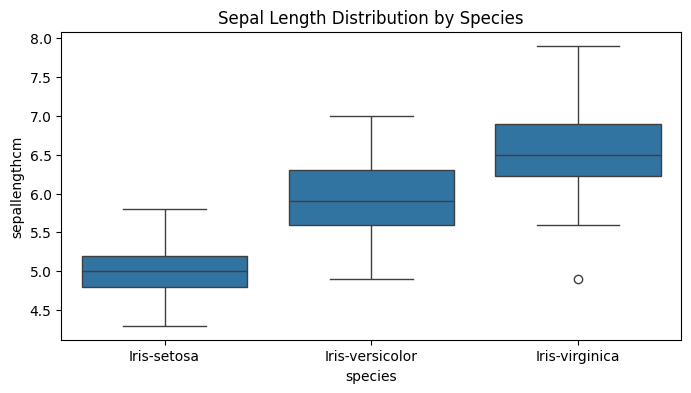

In [5]:
# Plot graphics from the dataframe
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x="species", y="sepallengthcm")
plt.title("Sepal Length Distribution by Species")
plt.show()

we are gonna take a look at the general distribution of each class and the correlation between the features

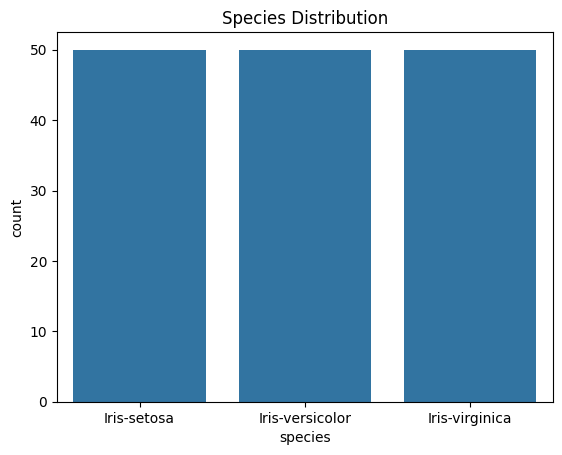

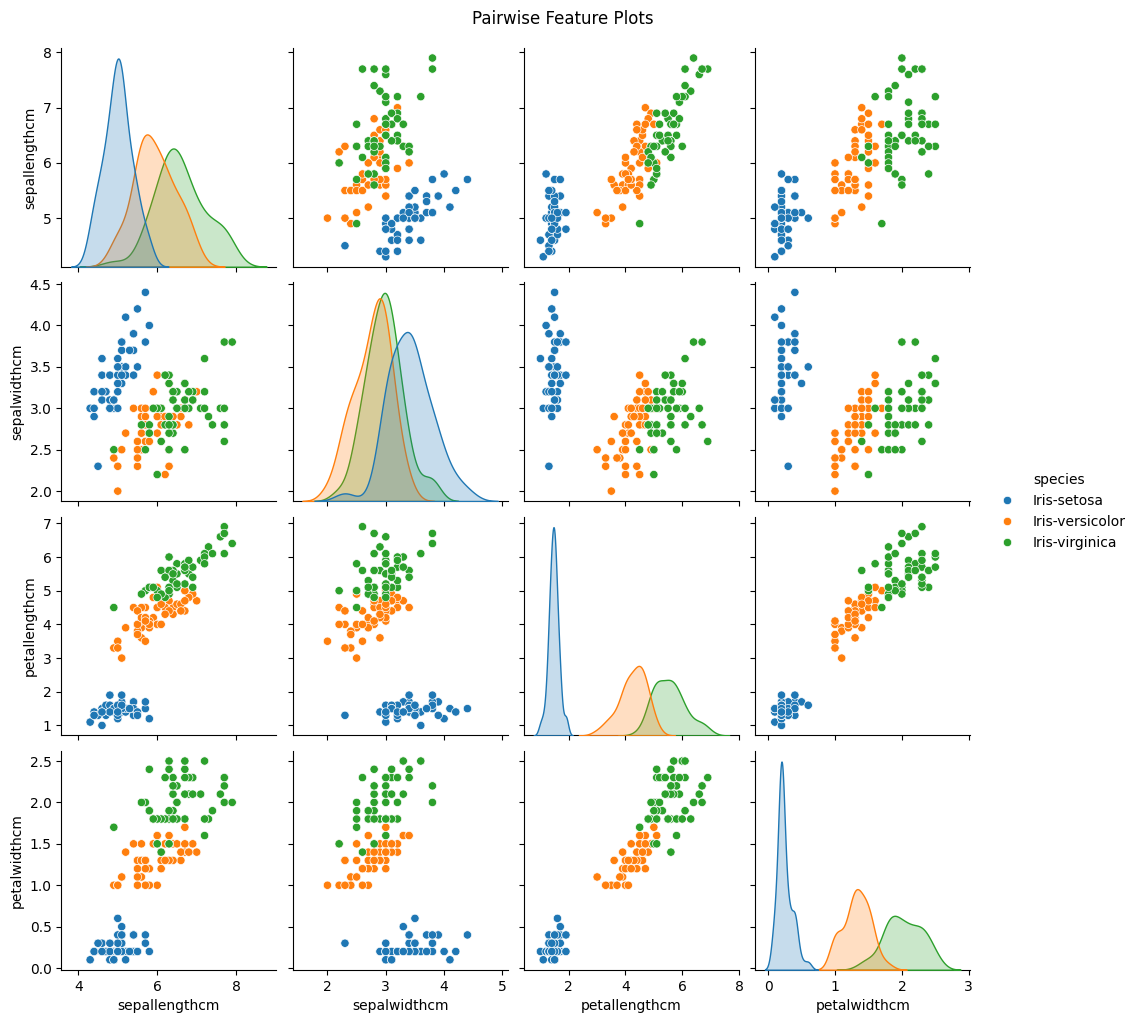

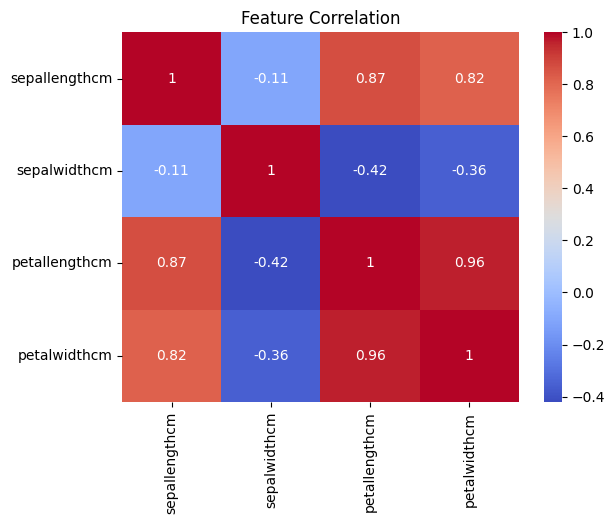

In [6]:
# Count of species
sns.countplot(data=df, x="species")
plt.title("Species Distribution")
plt.show()

# Pairplot
sns.pairplot(df, hue="species")
plt.suptitle("Pairwise Feature Plots", y=1.02)
plt.show()

# Heatmap
sns.heatmap(df.drop(columns=["species"]).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()


#### Split Train, Validation and Test

In [7]:
# Features and target
X = df.drop(columns=["species"])
y = df["species"]

# Split: 60% train, 20% val, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")


Train size: 90
Validation size: 30
Test size: 30


#### Model

In [8]:
# Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict based on validation dataset
y_val_pred = model.predict(X_val)

print("📋 Validation Results")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))


📋 Validation Results
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      0.90      0.90        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30



In [9]:
#Predict on test dataset
y_test_pred = model.predict(X_test)

print("📋 Test Results")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


📋 Test Results
[[10  0  0]
 [ 0 10  0]
 [ 0  3  7]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.77      1.00      0.87        10
 Iris-virginica       1.00      0.70      0.82        10

       accuracy                           0.90        30
      macro avg       0.92      0.90      0.90        30
   weighted avg       0.92      0.90      0.90        30



### Conclusions

The Random Forest Model was almost perfect to predict the species. The data contained in the table is precise and details the important aspects in the classification of species

### XAI Classic Model

Now we are gonna explain how the model makes its predictions and what features are most important for classification

First, we are gonna show a tree from the forest and how decisions are made considering this tree

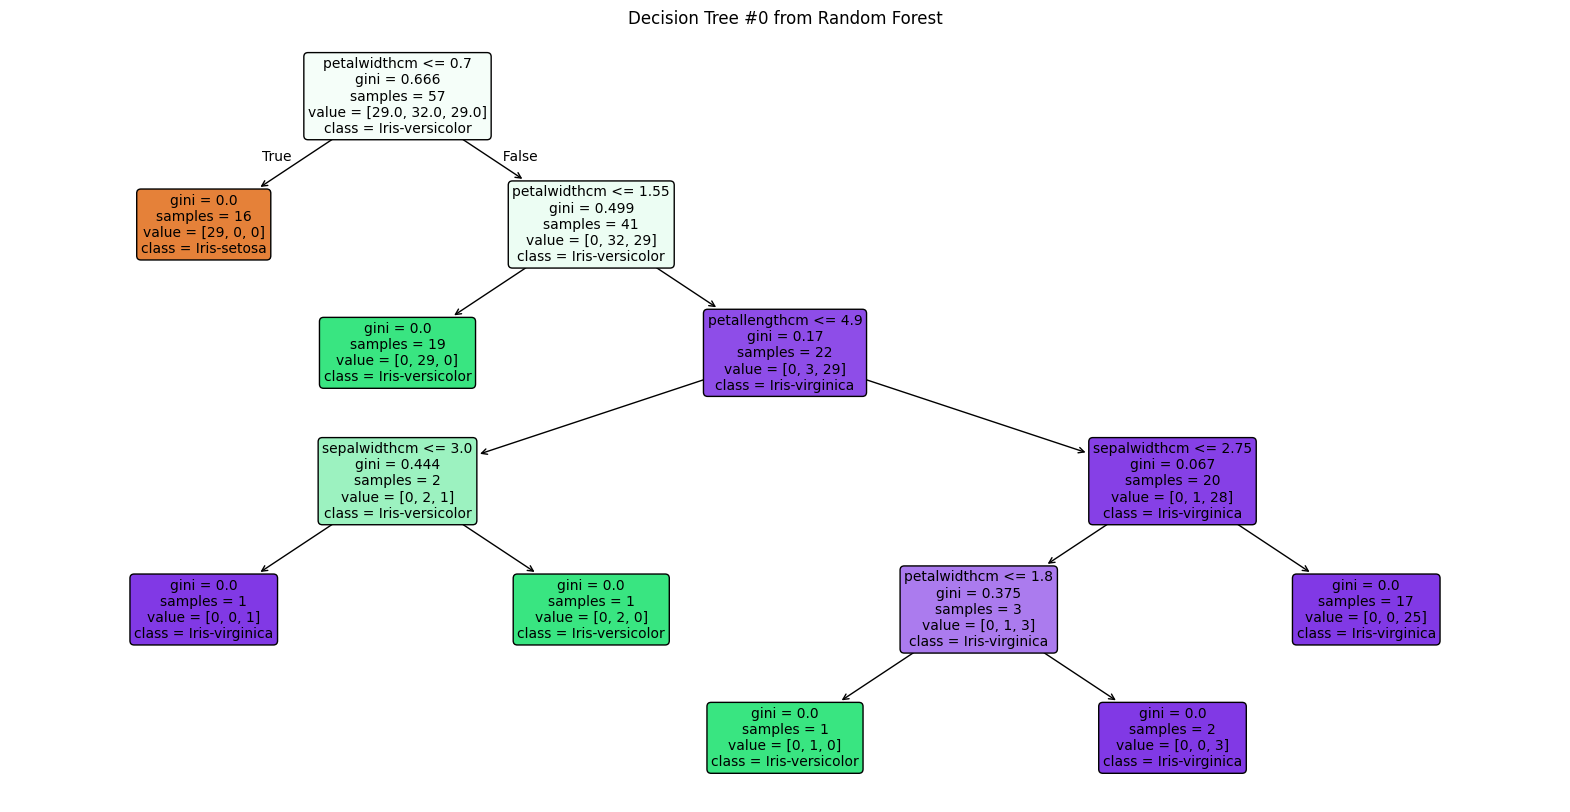

In [10]:
# Pick a tree (e.g., the first one)
tree = model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(tree,
          feature_names=X.columns,
          class_names=model.classes_,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree #0 from Random Forest")
plt.show()


Let's take a look at how each Iris is predicted. The columns show the average probability for each class label. The higher one is the final classification given by the model

In [11]:
# First 5 predicted labels and its probabilities from the validation dataset
print(model.predict(X_val[:5]))
print(model.predict_proba(X_val[:5]))


['Iris-virginica' 'Iris-setosa' 'Iris-virginica' 'Iris-versicolor'
 'Iris-versicolor']
[[0.   0.31 0.69]
 [1.   0.   0.  ]
 [0.   0.   1.  ]
 [0.   0.98 0.02]
 [0.07 0.93 0.  ]]


Now we are gonna look at the Gini index for each feature. The closer to 0, it means there is only one class option, the futher from 0, it means there are more uniform class distribution (the model is not able to categorize as one class)

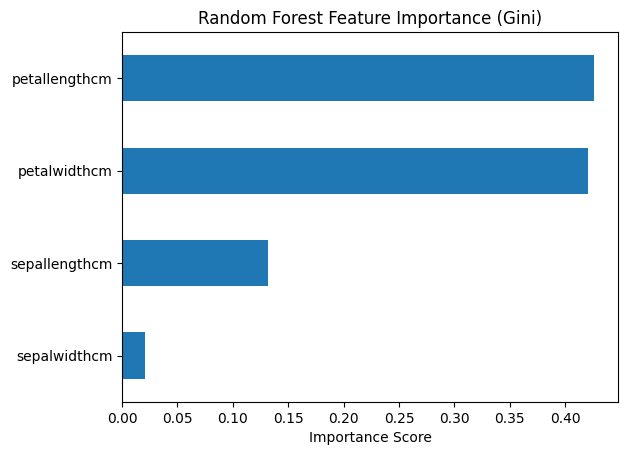

In [12]:
# Get importances
importances = model.feature_importances_

# Create a DataFrame
feat_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=True)

# Plot
feat_importance.plot(kind='barh')
plt.title("Random Forest Feature Importance (Gini)")
plt.xlabel("Importance Score")
plt.show()


Lastly, we are gonna plot a Permutation for each feature. It changes the values from one feature among themselves randomly. That allows us to see how important a feature is for the final prediction. If a feature is not important, we shouldn't see a big decrease in the model's accuracy.

In [13]:
# Run permutation importance on validation set
result_train = permutation_importance(model, X_train, y_train, n_repeats=20, random_state=42, n_jobs=-1)
result_val = permutation_importance(model, X_val, y_val, n_repeats=20, random_state=42, n_jobs=-1)
result_test = permutation_importance(model, X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1)

# Create DataFrame
perm_df_train = pd.Series(result_train.importances_mean * 100, index=X_train.columns).sort_values(ascending=True)
perm_df_val = pd.Series(result_val.importances_mean * 100, index=X_val.columns).sort_values(ascending=True)
perm_df_test = pd.Series(result_test.importances_mean * 100, index=X_test.columns).sort_values(ascending=True)

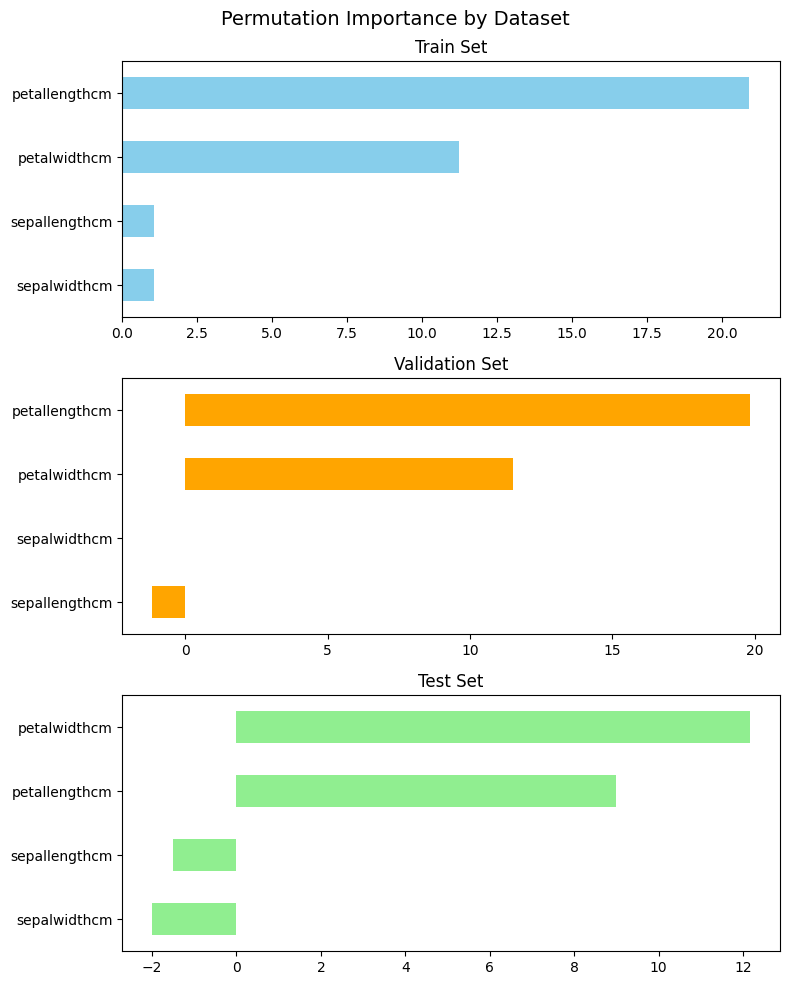

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))  # 3 rows, 1 column

perm_df_train.plot(kind='barh', ax=axes[0], color='skyblue', title="Train Set")
perm_df_val.plot(kind='barh', ax=axes[1], color='orange', title="Validation Set")
perm_df_test.plot(kind='barh', ax=axes[2], color='lightgreen', title="Test Set")

fig.suptitle("Permutation Importance by Dataset", fontsize=14)
plt.tight_layout()
plt.show()


It's interesting to see how one sample is classified. The cell below takes one row and separates by each class. Then it shows how each feature adds or subtracts for that class classification. The higher score is the final prediction.

In [15]:
# Pick a sample from validation set
sample_idx = 0
sample = X_val.iloc[sample_idx]
true_label = y_val.iloc[sample_idx]

print("True label:", true_label)
print("Predicted:", model.predict([sample])[0])

# Show explanation
eli5.show_prediction(model, sample.values, feature_names=X_val.columns.tolist())


True label: Iris-virginica
Predicted: Iris-virginica


c:\Users\LuizFernandoDaCostaC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\LuizFernandoDaCostaC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


#### Conclusions

From a global perspective the most importante feature when making a decision about the label for the Iris Dataset is the Petal Length and a close second place to Petal Width. We then permutated the values from all features to see how that would impact in the accuracy score and got expected results based on the importance of the two mentioned features to the overall classification.
Lastly, we focused on one prediction, that was classified as Iris-virginica and what counted pro and against that decision compared to the other possible classifications.

## Neural Network

### Import Dataset

In [16]:
# Download dataset
kaggle_path = kagglehub.dataset_download("alxmamaev/flowers-recognition")
print("Path to dataset files:", kaggle_path)

Path to dataset files: C:\Users\LuizFernandoDaCostaC\.cache\kagglehub\datasets\alxmamaev\flowers-recognition\versions\2


### Create Train, Validation and Test Datasets

In [17]:
# Take from original path and create subfolders
src_path = Path(kaggle_path) / "flowers"
# Define working directory where split folders will go
working_dir = Path.cwd()
split_root = working_dir / "split_flowers"

In [18]:
# Set seed for reproducibility
random.seed(42)

Let's remove duplicate images that might leak from train to val and test sets

In [19]:
# Compute image hashes and remove duplicates
print("🔍 Scanning for duplicate images...")
hash_to_path = {}
duplicates = []

for class_folder in src_path.iterdir():
    for img_path in class_folder.glob("*.jpg"):
        with open(img_path, 'rb') as f:
            h = hashlib.md5(f.read()).hexdigest()

        if h in hash_to_path:
            duplicates.append((img_path, hash_to_path[h]))
            img_path.unlink()  # delete duplicate
        else:
            hash_to_path[h] = img_path

# Report duplicates
if duplicates:
    print(f"⚠️ {len(duplicates)} duplicate image(s) found and deleted:")
    for dup, original in duplicates:
        print(f"🗑️  Duplicate: {dup} ⟶ Original: {original}")
else:
    print("✅ No duplicate images found.")

🔍 Scanning for duplicate images...
✅ No duplicate images found.


Let's split the species subfolders intro train, val and test, but maintaining the label folder

In [20]:
# Create split directories preserving label proportion
for split in ['train', 'val', 'test']:
    for class_folder in src_path.iterdir():
        (split_root / split / class_folder.name).mkdir(parents=True, exist_ok=True)

# Split and copy files
for class_folder in src_path.iterdir():
    images = list(class_folder.glob("*.jpg"))
    random.shuffle(images)
    n = len(images)
    n_train = int(0.6 * n)
    n_val = int(0.2 * n)
    
    splits = {
        "train": images[:n_train],
        "val": images[n_train:n_train + n_val],
        "test": images[n_train + n_val:]
    }

    for split_name, files in splits.items():
        for img in files:
            dst = split_root / split_name / class_folder.name / img.name
            shutil.copy(img, dst)

print("✅ Images split into train/val/test at:", split_root)


✅ Images split into train/val/test at: c:\Users\LuizFernandoDaCostaC\Box\pessoal\Pessoal\Github\Explainable-AI-Applied-To-Random-Forest-And-MobileNetV2\split_flowers


It's important not to have data leakage from train to other sets, so we are gonna check if there are folder with the same name and do another check on the images

In [21]:
# Collect filenames
file_records = defaultdict(set)

for split in ['train', 'val', 'test']:
    for class_folder in (split_root / split).iterdir():
        for img_file in class_folder.glob("*.jpg"):
            key = (class_folder.name, img_file.name)  # (class, filename)
            if key in file_records:
                print("⚠️ Duplicate detected across splits:", key)
            file_records[key].add(split)

# Recheck if there are no duplicate files

def hash_image(img_path):
    with open(img_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

hashes = defaultdict(list)

for split in ['train', 'val', 'test']:
    for class_folder in (split_root / split).iterdir():
        for img_file in class_folder.glob("*.jpg"):
            h = hash_image(img_file)
            hashes[h].append((split, class_folder.name, img_file.name))

# Show any hash appearing in multiple splits
for h, entries in hashes.items():
    if len(set(split for split, _, _ in entries)) > 1:
        print("⚠️ Duplicate image content found across splits:", entries)


### Resize images

We are gonna resize images to 128x128 as it is less computationally expensive

In [22]:
# Parameters
IMG_SIZE = 128
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Paths
split_root = Path.cwd() / "split_flowers"
resized_root = Path.cwd() / "resized_flowers"

We are gonna create another folder with subfolder but this time the images are gonna be resized to 128x128. This is computationally expensive, but it is clearer and more confident that the changes we requested have been made. Also it allows us to compare the original image and the resized one in case we wanna see the effects future augmentation will have on images

In [23]:
# Ensure resized structure is the same as split
for split_dir in split_root.iterdir():
    for class_dir in split_dir.iterdir():
        target_dir = resized_root / split_dir.name / class_dir.name
        target_dir.mkdir(parents=True, exist_ok=True)

# Resize images and save to new location
def resize_and_save_images():
    for split_dir in split_root.iterdir():
        for class_dir in split_dir.iterdir():
            for img_path in class_dir.glob("*.jpg"):
                with Image.open(img_path) as img:
                    img = img.convert("RGB")
                    img_resized = tf.image.resize_with_pad(
                        tf.convert_to_tensor(np.array(img)), IMG_SIZE, IMG_SIZE
                    )
                    save_path = resized_root / split_dir.name / class_dir.name / img_path.name
                    tf.keras.preprocessing.image.save_img(
                        str(save_path), img_resized.numpy(), file_format='jpeg'
                    )
    print("✅ All images resized with aspect ratio and saved to:", resized_root)

resize_and_save_images()

✅ All images resized with aspect ratio and saved to: c:\Users\LuizFernandoDaCostaC\Box\pessoal\Pessoal\Github\Explainable-AI-Applied-To-Random-Forest-And-MobileNetV2\resized_flowers


### Preparing the dataset for model

Before we train the model, we are gonna set a few parameters that will be useful for the training

In [24]:
# Data augmentation
augmenter = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
])

Let's train the moel considering the weight each class has

In [25]:
# Load datasets from resized folders
def load_dataset(split, augment=False, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        resized_root / split,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )
    if augment:
        ds = ds.map(lambda x, y: (augmenter(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

# 🔹 Load raw dataset ONLY for getting class names and computing class weights
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    resized_root / "train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# ✅ Get class names
class_names = raw_train_ds.class_names
num_classes = len(class_names)
print("📂 Classes found:", class_names)

# ✅ Compute class weights
all_train_labels = []
for _, labels in raw_train_ds.unbatch():
    all_train_labels.append(labels.numpy())

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(all_train_labels),
    y=all_train_labels
)
class_weights_dict = dict(enumerate(class_weights))
print("📊 Class weights:", class_weights_dict)

# ✅ Now load the processed datasets
train_ds = load_dataset("train", augment=True)
val_ds = load_dataset("val", augment=False)
test_ds = load_dataset("test", augment=False, shuffle=False)

Found 2585 files belonging to 5 classes.
📂 Classes found: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
📊 Class weights: {0: np.float64(1.1288209606986899), 1: np.float64(0.8193343898573693), 2: np.float64(1.1), 3: np.float64(1.1803652968036529), 4: np.float64(0.8792517006802721)}
Found 2585 files belonging to 5 classes.
Found 860 files belonging to 5 classes.
Found 866 files belonging to 5 classes.


In [26]:
# Load one image from the training dataset
sample_ds = tf.keras.utils.image_dataset_from_directory(
    resized_root / "train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    shuffle=True
)

# Take one batch (one image + label)
for images, labels in sample_ds.take(1):
    img = images[0]
    print("📐 Shape:", img.shape)
    print("📦 Dtype:", img.dtype)
    print("🎨 Channels:", img.shape[-1])  # This is the number of channels


Found 2585 files belonging to 5 classes.
📐 Shape: (128, 128, 3)
📦 Dtype: <dtype: 'float32'>
🎨 Channels: 3


Found 2585 files belonging to 5 classes.


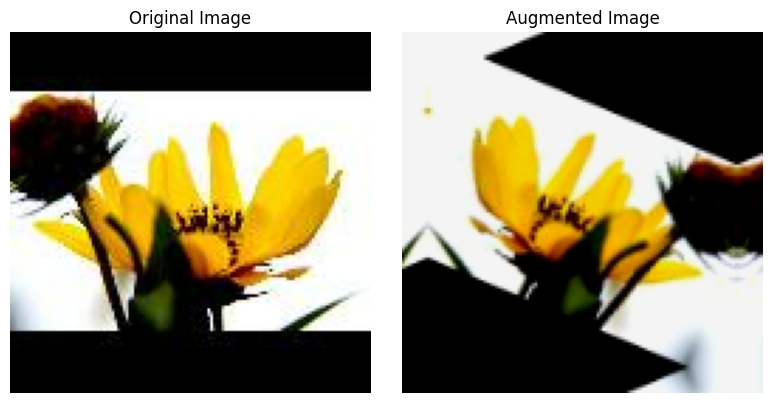

In [27]:
# Load one image from the dataset without preprocessing
plain_ds = tf.keras.utils.image_dataset_from_directory(
    resized_root / "train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    shuffle=True
)

# Apply augmentation (but not preprocess_input)
for images, labels in plain_ds.take(1):
    original = images[0]
    augmented = augmenter(tf.expand_dims(original, 0), training=True)[0]

    # Plot
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original.numpy().astype("uint8"))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(tf.clip_by_value(augmented, 0, 255).numpy().astype("uint8"))
    plt.title("Augmented Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


### Model

In [28]:
# Step 5: Build the MobileNetV2 model with additional dense layer
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze base model

# Functional API
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,293 (8.93 MB)

 Trainable params: 82,309 (321.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Let's set an early_stop and a reduce_lr. Early stop will be useful to prevent training to keep going if validation accuracy drops. Reduce LR will be used during fine-tuning.

In [29]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=9,             # stop after 7 epochs with no improvement
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # metric to monitor
    factor=0.5,            # LR is reduced by this factor
    patience=2,            # wait 2 epochs before reducing LR
    verbose=1,
    min_lr=1e-7
)

Now let's train the model considering the class weights we set previously

In [30]:
# Train the model with class weights
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 59s 589ms/step - accuracy: 0.5016 - loss: 1.4226 - val_accuracy: 0.7651 - val_loss: 0.6710
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 46s 563ms/step - accuracy: 0.7310 - loss: 0.7400 - val_accuracy: 0.7826 - val_loss: 0.6058
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 45s 544ms/step - accuracy: 0.7661 - loss: 0.6277 - val_accuracy: 0.7593 - val_loss: 0.6142
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 48s 584ms/step - accuracy: 0.7878 - loss: 0.5848 - val_accuracy: 0.8012 - val_loss: 0.5898
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 45s 542ms/step - accuracy: 0.7847 - loss: 0.5740 - val_accuracy: 0.8105 - val_loss: 0.5805
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 46s 555ms/step - accuracy: 0.8205 - loss: 0.5230 - val_accuracy: 0.8116 - val_loss: 0.5348
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 46s 552ms/step - accuracy: 0.8372 - loss: 0.4687 - val_accuracy: 0.8000 - val_loss: 0.5626
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 46s 554ms/step - accuracy: 0.8363 - loss: 0.4744 - val_accu

A fine tuning to improve the overall model

In [31]:
# Now Fine-tuning
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR for fine-tuning
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.6618 - loss: 0.9706 - val_accuracy: 0.8326 - val_loss: 0.5316 - learning_rate: 1.0000e-05
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7308 - loss: 0.7780 - val_accuracy: 0.8360 - val_loss: 0.5298 - learning_rate: 1.0000e-05
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.7646 - loss: 0.6733 - val_accuracy: 0.8302 - val_loss: 0.5288 - learning_rate: 1.0000e-05
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7740 - loss: 0.6242 - val_accuracy: 0.8360 - val_loss: 0.5412 - learning_rate: 1.0000e-05
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7833 - loss: 0.5958
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7834 - loss: 0.5957 - val_accuracy: 0.8360 - val_loss: 0.5367 - learning_rate: 1.0000e-05


In [32]:
# Step 7: Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.2%}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 431ms/step - accuracy: 0.8520 - loss: 0.5138
✅ Test Accuracy: 83.37%


### Result's Analysis

First let's plot a graph that shows us the accuracy evolution per epoch

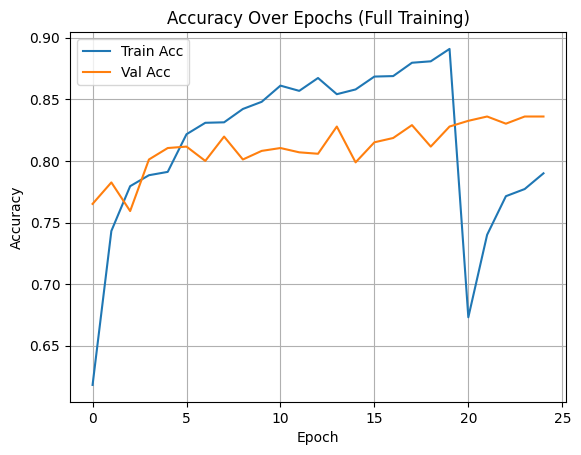

In [33]:
# Step 3: Combine history
full_history = {
    'accuracy': history1.history['accuracy'] + history2.history['accuracy'],
    'val_accuracy': history1.history['val_accuracy'] + history2.history['val_accuracy'],
    'loss': history1.history['loss'] + history2.history['loss'],
    'val_loss': history1.history['val_loss'] + history2.history['val_loss'],
}

# Step 4: Plot
plt.plot(full_history['accuracy'], label='Train Acc')
plt.plot(full_history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs (Full Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

We can see that while train accuracy increased greatly during epochs, validation accuracy increased during the first half of the epochs and then stagnated

Now let's plot a small report to see a few statistics about the predictions and some of the misclassified labels

In [34]:
# Step 1: Predict class probabilities on test set
pred_probs = model.predict(test_ds)

# Step 2: Convert predicted probabilities to predicted class indices
predicted_indices = np.argmax(pred_probs, axis=1)

# Step 3: Get true class indices from test_ds
true_indices = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Step 4: Get mapping from indices to class names
idx_to_class = dict(enumerate(class_names))  # You already defined class_names earlier

# Classification report with precision, recall, f1-score by class
print(classification_report(true_indices, predicted_indices, target_names=list(idx_to_class.values())))

# Find misclassified indices
misclassified_indices = np.where(true_indices != predicted_indices)[0]

# Create a list of (true_class, predicted_class) for errors
errors = [(idx_to_class[true_indices[i]], idx_to_class[predicted_indices[i]]) for i in misclassified_indices]

# Count occurrences of each error pair
error_counts = Counter(errors)

print("🔍 Misclassification counts (True class -> Predicted class):")
for (true_cls, pred_cls), count in error_counts.items():
    print(f"{true_cls} -> {pred_cls}: {count}")


28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 408ms/step
              precision    recall  f1-score   support

       daisy       0.84      0.87      0.86       154
   dandelion       0.92      0.87      0.89       211
        rose       0.79      0.75      0.77       158
   sunflower       0.84      0.86      0.85       147
       tulip       0.77      0.82      0.79       196

    accuracy                           0.83       866
   macro avg       0.83      0.83      0.83       866
weighted avg       0.84      0.83      0.83       866

🔍 Misclassification counts (True class -> Predicted class):
daisy -> tulip: 2
daisy -> dandelion: 9
daisy -> sunflower: 5
daisy -> rose: 4
dandelion -> sunflower: 9
dandelion -> rose: 3
dandelion -> daisy: 9
dandelion -> tulip: 7
rose -> tulip: 31
rose -> daisy: 6
rose -> dandelion: 1
rose -> sunflower: 2
sunflower -> tulip: 8
sunflower -> rose: 4
sunflower -> dandelion: 3
sunflower -> daisy: 5
tulip -> rose: 21
tulip -> sunflower: 8
tulip -> daisy: 5
tulip -> dand

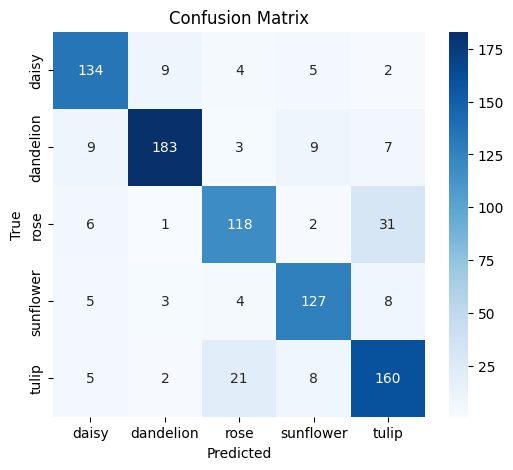

In [35]:
# Generate the confusion matrix
cm = confusion_matrix(true_indices, predicted_indices)

# Use the class names from your dataset
class_labels = class_names

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### XAI Convolutional Model

Now let's take a look at Grad-CAM to understand how our model makes its predictions and the important areas it has considered

First we take one random image to see what the model "saw" for making its prediction

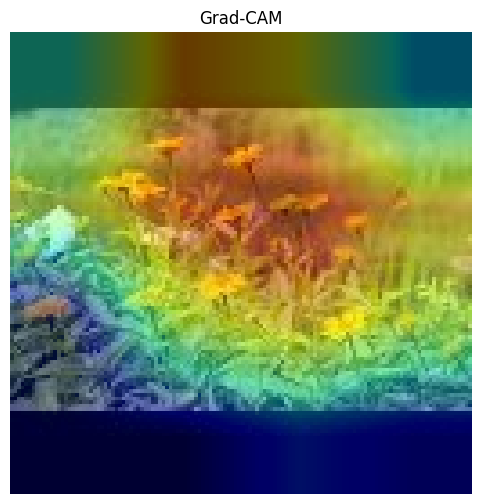

In [36]:
# Access base MobileNetV2 inside the full model
mobilenet_layer = model.get_layer('mobilenetv2_1.00_128')

# Identify the last conv layer name inside mobilenet_layer (it's Conv_1)
last_conv_layer_name = 'Conv_1'  

# Input layer is the same as the full model's input
inputs = model.input

# Create an inner model to get last conv output from mobilenet_layer
inner_mobilenet = tf.keras.models.Model(
    inputs=mobilenet_layer.input,
    outputs=mobilenet_layer.get_layer(last_conv_layer_name).output
)

# Run input through inner_mobilenet
conv_outputs = inner_mobilenet(inputs)

# Get output from mobilenet_layer (the feature map output)
mobilenet_output = mobilenet_layer(inputs)

# For safety, manually build that part:
x = conv_outputs  # conv outputs from inner model
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(
    64,
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)
)(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create a new model that outputs conv_outputs and the final predictions
gradcam_model = tf.keras.models.Model(inputs=inputs, outputs=[conv_outputs, outputs])

# Define the Grad-CAM heatmap function
def make_gradcam_heatmap(img_array, gradcam_model, pred_index=None):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = gradcam_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    if grads is None:
        raise RuntimeError("Gradient is None. Check connection between layers.")
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    heatmap = heatmap.numpy()
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)
    heatmap = tf.image.resize(heatmap, (img_array.shape[1], img_array.shape[2])).numpy()
    heatmap = heatmap[..., 0] / 255.0
    return heatmap, pred_index.numpy()

# Visualize function
def display_gradcam(img_tensor, heatmap, alpha=0.4):
    img = img_tensor[0].numpy()
    img = (img + 1.0) / 2.0  # Undo MobileNetV2 preprocessing (which scales to [-1,1])
    img = np.clip(img, 0, 1)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=alpha)
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()

# Run on one test image
for images, labels in test_ds.take(1):
    img = images[1:2]
    heatmap, pred_idx = make_gradcam_heatmap(img, gradcam_model)
    display_gradcam(img, heatmap)


Lastly, we are gonna analyze one correct and one wrong prediction that has been made and what our model used to make the prediction

In [37]:
# Set variables for the next cell
correct_img = None
wrong_img = None
correct_true_label = None
correct_pred_label = None
wrong_true_label = None
wrong_pred_label = None

for images, labels in test_ds.unbatch().batch(1).take(100):  # check first 100 samples
    pred = model.predict(images, verbose=0)
    true_label = tf.argmax(labels[0]).numpy() if labels.shape[-1] > 1 else labels[0].numpy()
    pred_label = tf.argmax(pred[0]).numpy()

    if pred_label == true_label and correct_img is None:
        correct_img = images
        correct_true_label = class_names[true_label]
        correct_pred_label = class_names[pred_label]

    elif pred_label != true_label and wrong_img is None:
        wrong_img = images
        wrong_true_label = class_names[true_label]
        wrong_pred_label = class_names[pred_label]

    if correct_img is not None and wrong_img is not None:
        break

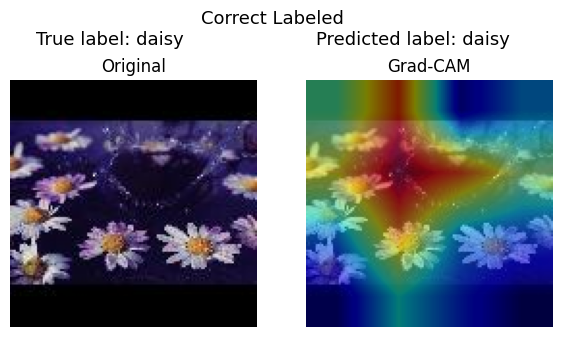

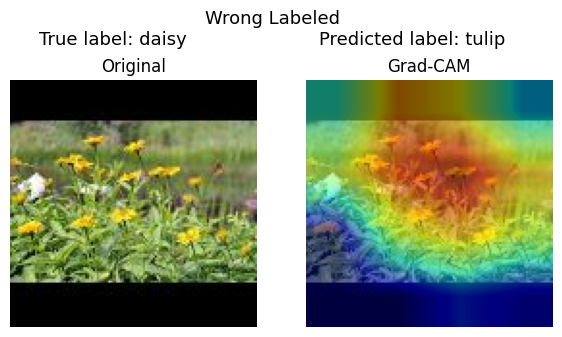

In [38]:
# Define functions to plot graphic
def plot_pair(img_tensor, heatmap, main_title, true_label, pred_label):
    img = img_tensor.numpy()
    img = (img + 1.0) / 2.0  # Undo MobileNetV2 preprocessing (-1 to 1 range)
    img = np.clip(img, 0, 1)

    plt.figure(figsize=(7, 4))
    plt.suptitle(f"{main_title}\nTrue label: {true_label}                       Predicted label: {pred_label}", fontsize=13)

    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.axis('off')
    plt.title("Original")

    plt.subplot(1, 2, 2)
    plt.imshow(img[0])
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title("Grad-CAM")

    plt.show()

correct_heatmap, _ = make_gradcam_heatmap(correct_img, gradcam_model)
wrong_heatmap, _ = make_gradcam_heatmap(wrong_img, gradcam_model)

plot_pair(correct_img, correct_heatmap, "Correct Labeled", correct_true_label, correct_pred_label)
plot_pair(wrong_img, wrong_heatmap, "Wrong Labeled", wrong_true_label, wrong_pred_label)


Delete created folders to clean memory

In [39]:
#Delete iris_resized folder for easiness of rerunning the model without duplicating the samples in the folder

resized_path = "resized_flowers"

if os.path.exists(resized_path):
    shutil.rmtree(resized_path)
    print(f"✅ Folder '{resized_path}' deleted successfully.")
else:
    print(f"⚠️ Folder '{resized_path}' does not exist.")

split_path = "split_flowers"

if os.path.exists(split_path):
    shutil.rmtree(split_path)
    print(f"✅ Folder '{split_path}' deleted successfully.")
else:
    print(f"⚠️ Folder '{split_path}' does not exist.")

✅ Folder 'resized_flowers' deleted successfully.
✅ Folder 'split_flowers' deleted successfully.


### Conclusions

Despite the inferior performance of the Convolutional Neural Network (CNN) model, it is remarkable to observe the evolution of computing in image recognition. The tabular data provided for the classical model is more efficient for correctly classifying species; however, this type of information is not always available. It also requires meticulous work by specialists and significant human effort for precise measurements that do not compromise data quality. The classical model, although more accurate, is still susceptible to human error and efficiency.

The Convolutional model stands out for its ability to automatically and scalably classify real images. Once properly trained and using appropriate generalization techniques, this network can recognize species with high accuracy. Furthermore, the ability to use robust pre-trained architectures, such as MobileNetV2, and transfer their knowledge (transfer learning) to an entirely new dataset, only needing to fine-tune the training in the final epochs, represents a significant saving in time and resources.

From the perspective of model explainability, the classical model is undeniably clearer regarding the boundaries of each class and the impact of each parameter on the final classification. However, the Convolutional model offers a more "human" way of classifying. By showing us the areas of the image that the neurons focused on to reach the final result, it mirrors human visual reasoning and allows us to clearly see whether it observed the correct region and what is visually important for making a decision.